In [1]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib inline


 Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones, a particularly useful application is estimation of rolling parameters of the data. When using a Kalman filter, there's no window length that we need to specify.
 
 This is useful for computing the moving average, or for smoothing out estimates of other quantities. For instance, if we have already computed the moving Sharpe ratio, we can smooth it using a Kalman filter.

Below, we'll use both a Kalman filter and an n-day moving average to estimate the rolling mean of a dataset. We hope that the mean describes our observations well, so it shouldn't change too much when we add an observation; therefore, we assume that it evolves as a random walk with a small error term. The mean is the model's guess for the mean of the distribution from which measurements are drawn, so our prediction of the next value is simply equal to our estimate of the mean. We assume that the observations have variance 1 around the rolling mean, for lack of a better estimate. Our initial guess for the mean is 0, but the filter quickly realizes that that is incorrect and adjusts.

In [2]:
yf.pdr_override() #需要调用这个函数

# 获取数据
data = pdr.get_data_yahoo("SPY", start="2016-01-15", end="2019-05-15")
#data = pdr.get_data_yahoo(["SPY", "IWM"], start="2017-01-01", end="2017-04-30")
x = data['Close']
#print(x)

[*********************100%***********************]  1 of 1 downloaded


E:\py\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


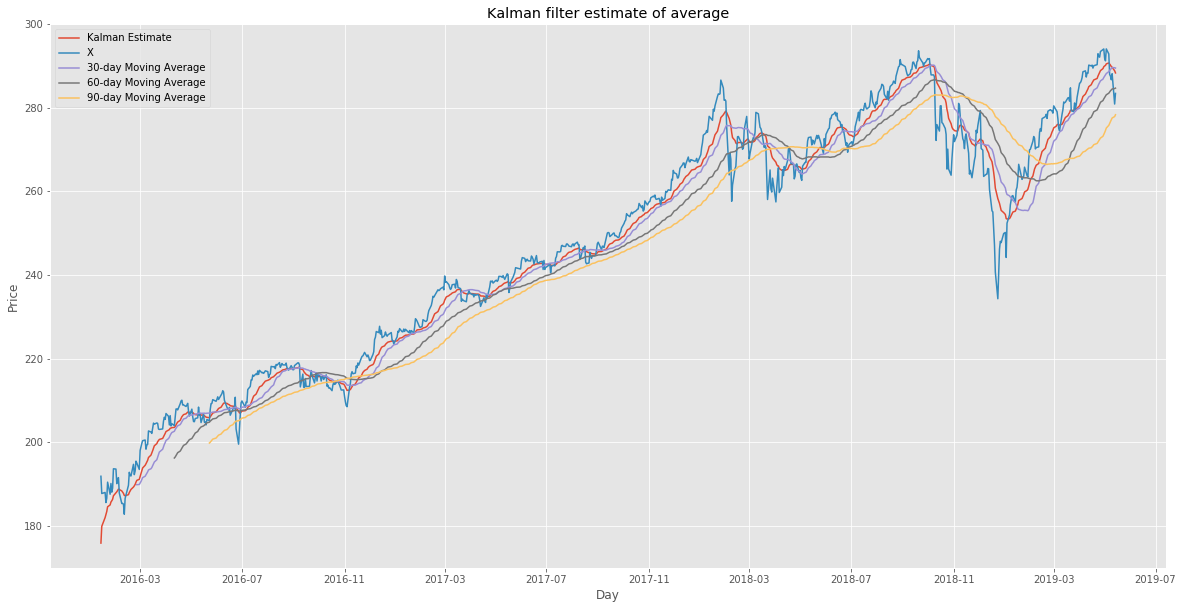

In [3]:

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 160,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(window = 30).mean()
mean60 = x.rolling(window = 60).mean()
mean90 = x.rolling(window = 90).mean()

# Plot original data and estimated mean
plt.figure(figsize=(20,10))
plt.plot(state_means)
plt.plot(x)
plt.plot(mean30)
plt.plot(mean60)
plt.plot(mean90)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

#plot a subsection of the graph.

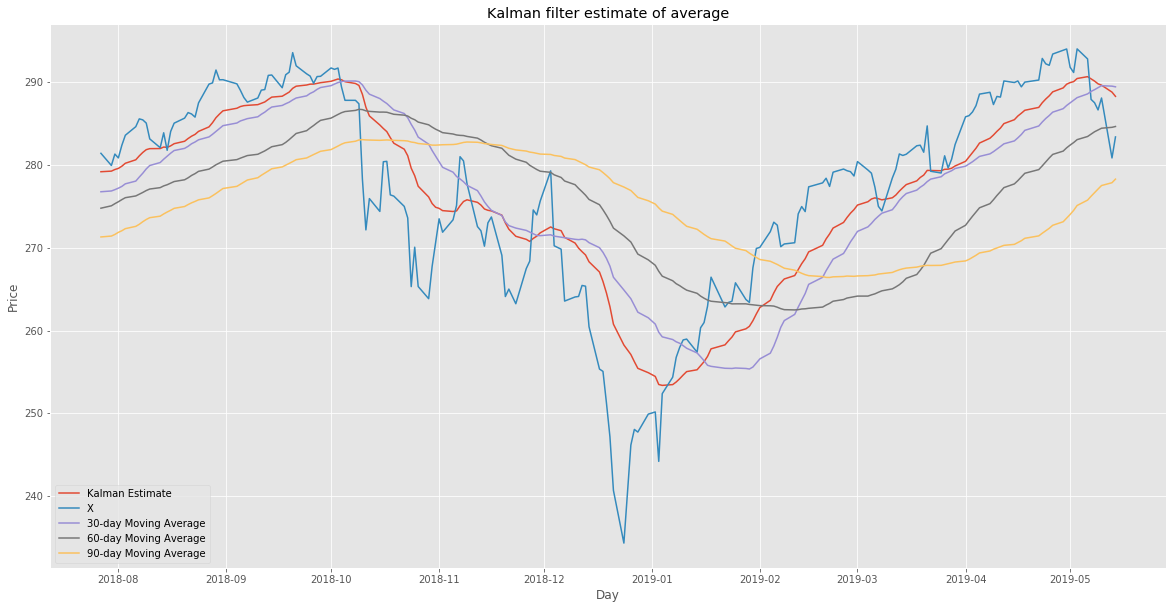

In [4]:
plt.figure(figsize=(20,10))
plt.plot(state_means[-200:])
plt.plot(x[-200:])
plt.plot(mean30[-200:])
plt.plot(mean60[-200:])
plt.plot(mean90[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

The advantage of the Kalman filter is that we don't need to select a window length, so we run less risk of overfitting. We do open ourselves up to overfitting with some of the initialization parameters for the filter, but those are slightly easier to objectively define. There's no free lunch and we can't eliminate overfitting, but a Kalman Filter is more rigorous than a moving average and generally better.